## Famous Iris data set (flower data)

pro: small data set, but 4D, and maybe impossible to cluster into the three groups of flowers according to wikipedia.  can be compared to the clustering into setosa, versicolor, virginica (three types of the flower). one could hope that if one looks for three clusters, one will get the three meaningful ones.

con: see e.g. https://en.wikipedia.org/wiki/Iris_flower_data_set:
"Based on Fisher's linear discriminant model, this data set became a typical test case for many statistical classification techniques in machine learning such as support vector machines.
The use of this data set in cluster analysis however is not common, since the data set only contains two clusters with rather obvious separation. One of the clusters contains Iris setosa, while the other cluster contains both Iris virginica and Iris versicolor and is not separable without the species information Fisher used. This makes the data set a good example to explain the difference between supervised and unsupervised techniques in data mining: Fisher's linear discriminant model can only be obtained when the object species are known: class labels and clusters are not necessarily the same."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from consensus_clustering.load_data import load_iris, load_iris_labeled
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn.apionly as sns
#sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Data

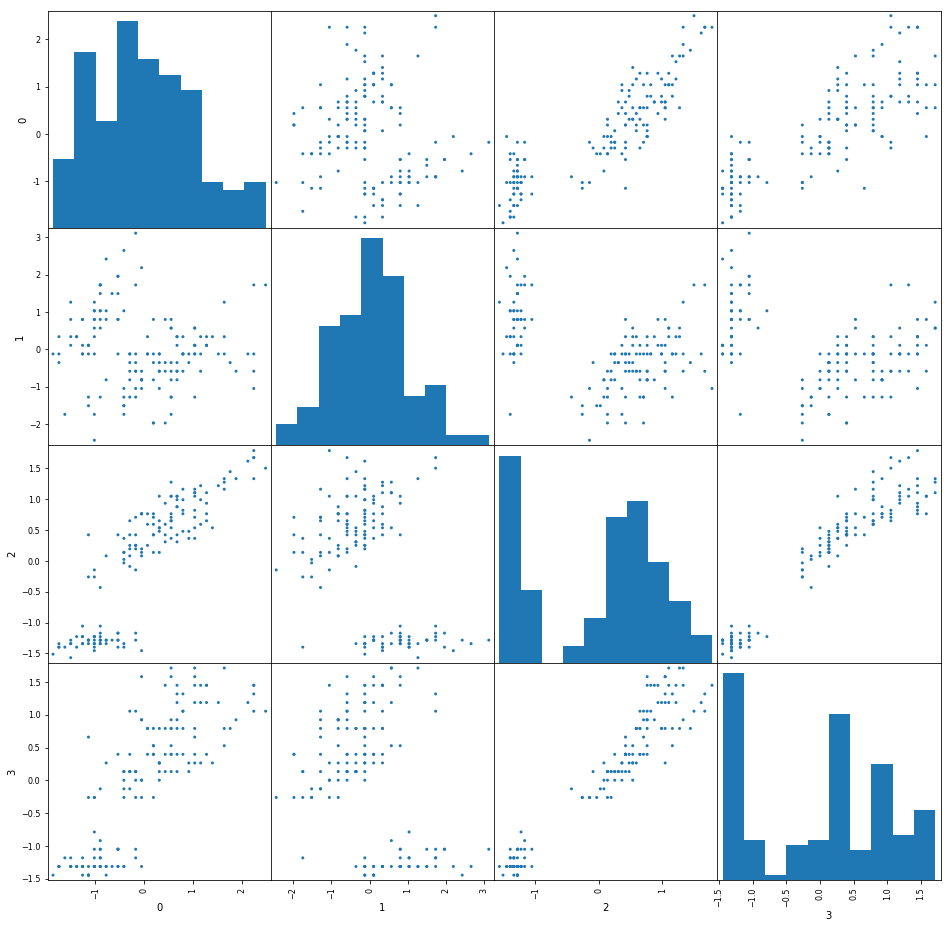

In [2]:
#load data (unlabeled)
data=load_iris(scale = 'True') #preprocess data

#visualize as 4x4 plots, for each of the 4 dimensions
s=scatter_matrix(pd.DataFrame(data), alpha=1, figsize=(16, 16), cmap='Set2')

### DBSCAN Example

In [3]:
dbscan_obj = density.DBSCAN(data,eps=1, minPts=5)
dbscan_obj.fit()
labels = dbscan_obj._cluster_labels

Detected 2 clusters
Finished after 0:00:00.013295
Rate of noise in dataset: 0.020000


DBSCAN clustering results (parameters for DBSCAN chosen by trying out different values)

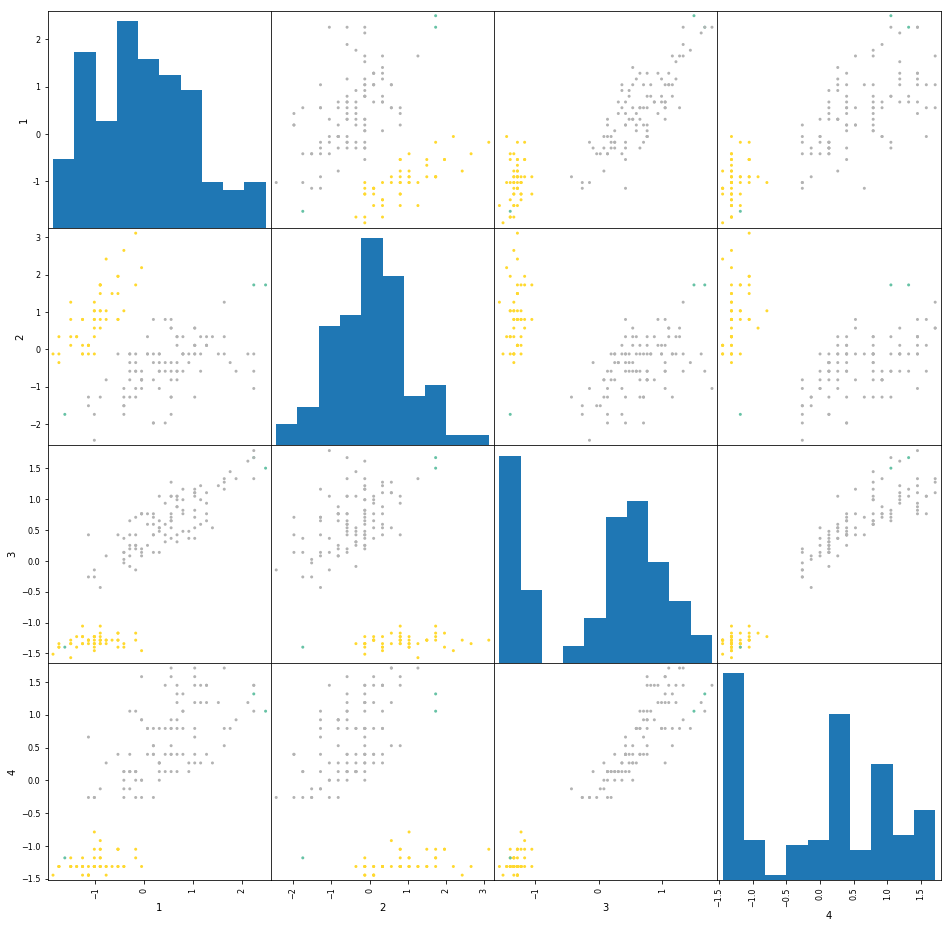

In [4]:
dataframeds=pd.DataFrame(data,columns=["1","2","3","4"])
dataframeds["labels"]=labels
s=scatter_matrix(dataframeds[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = labels, cmap='Set2')

### Mean Shift Algorithm, another density-based method

92 iterations until termination.
Used bandwidth: 0.370000
Finished after 0.45853630230885756
Number of clusters found: 4.000000
There is/are 1.000000 outliers
Max within cluster distance to center: 0.014051
Mean within cluster distance to center: 0.006304
Sum of within cluster squared errors: 0.008267


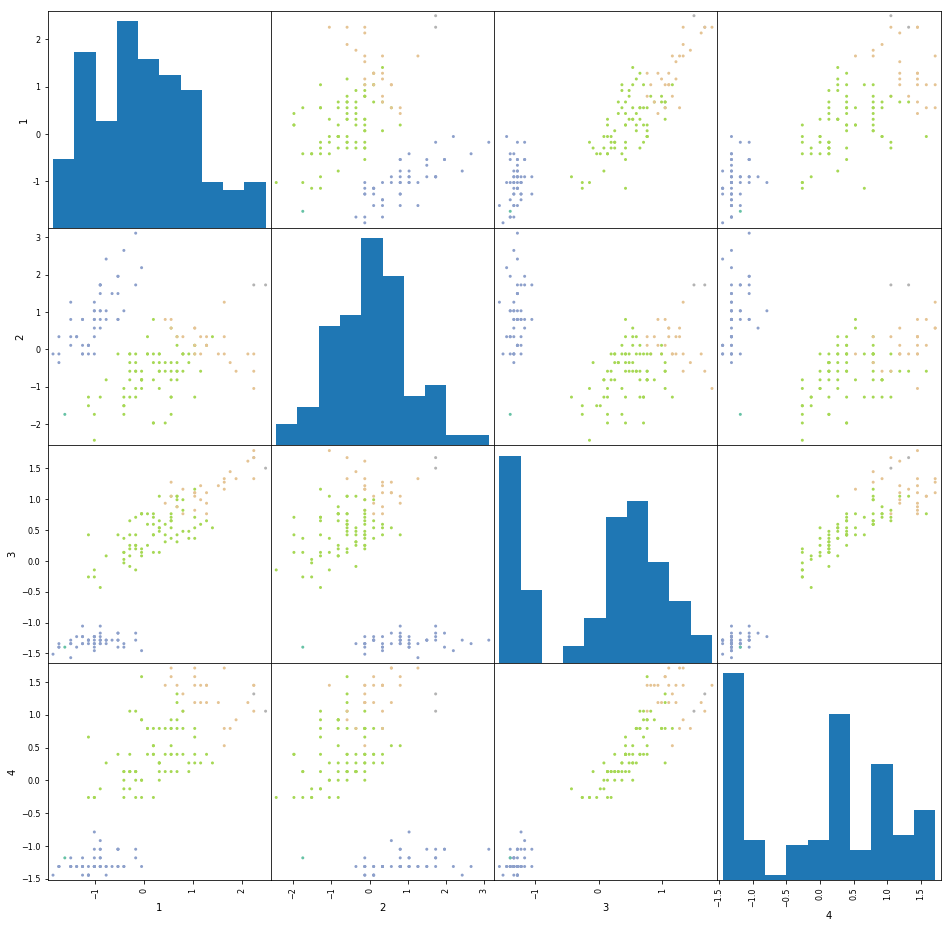

In [26]:
#mean shift algorithm
ms_obj = density.MeanShift(data, bandwidth=0.37, mindist=0.03)
ms_obj.fit()
labels = ms_obj.cluster_labels

#visualization as 4x4 plots for each of the 4 dimensions
dataframems=pd.DataFrame(data,columns=["1","2","3","4"])
dataframems["labels"]=labels
s=scatter_matrix(dataframems[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = labels, cmap='Set2')

### K-Means with three clusters

terminated by break condition
7 iterations until termination.
Finished after 0:00:00.005339
max within-cluster distance to center: 2.661397
mean within-cluster distance to center: 0.864104
sum of within cluster squared errors: 140.965813


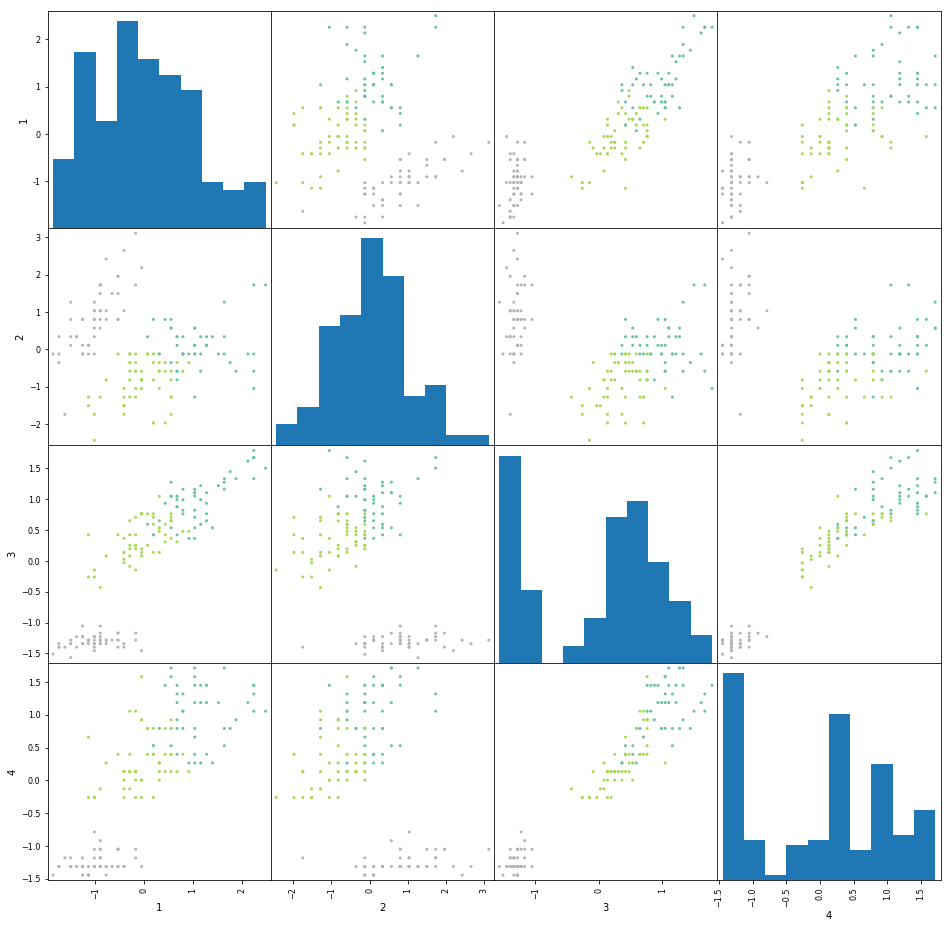

In [27]:
k = 3

# Fit
kmeans_obj = cl_dist.KMeans(data, k)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels

# Plot
dataframekm=pd.DataFrame(data,columns=["1","2","3","4"])
dataframekm["labels"]=labels
s=scatter_matrix(dataframekm[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = labels, cmap='Set2')

### Spectral Clustering with three clusters

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
8 iterations until termination.
Finished after 0:00:00.009670
max within-cluster distance to center: 1.669007
mean within-cluster distance to center: 0.288436
sum of within cluster squared errors: 22.585204
KMeans terminated. 

Finished after 0:00:00.040283


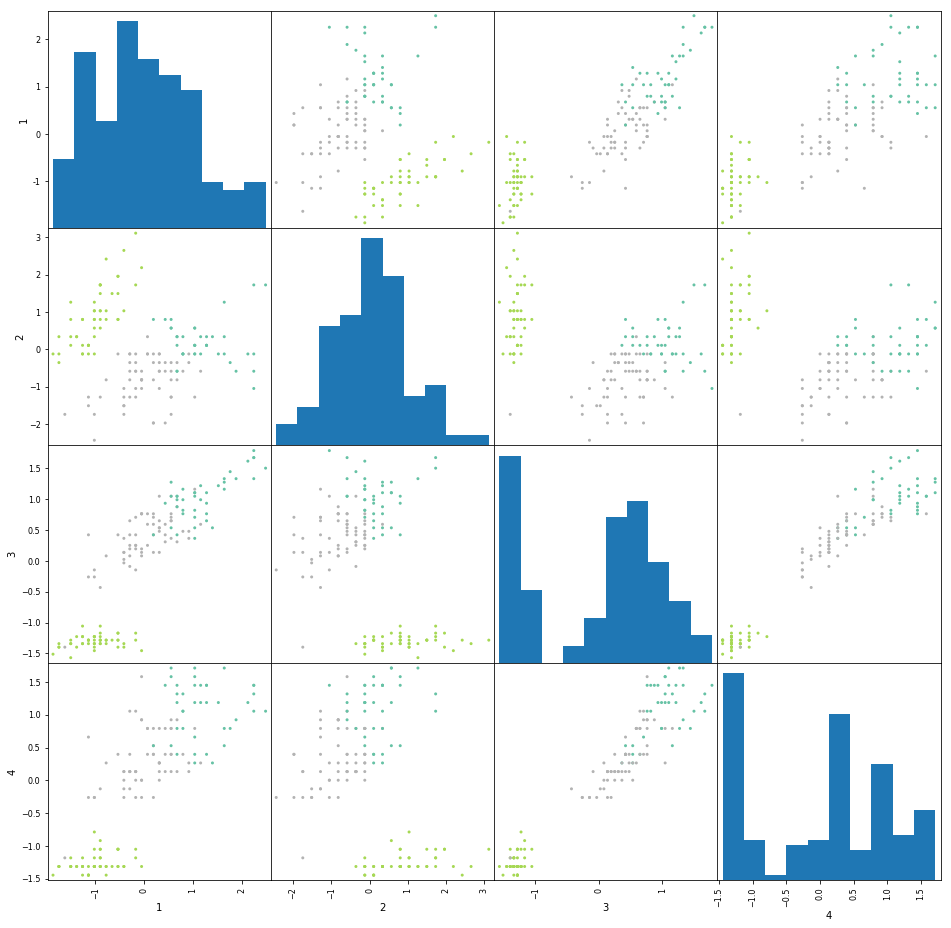

In [28]:
k = 3
bandwidth = 2

# Fit
spectral_obj = similarity.SpectralClustering(data, k=k, bandwidth=bandwidth)
spectral_obj.fit()
labels = spectral_obj.cluster_labels

# Plot
dataframesp=pd.DataFrame(data,columns=["1","2","3","4"])
dataframesp["labels"]=labels
s=scatter_matrix(dataframesp[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = labels, cmap='Set2')

### Consensus clustering

Now we are ready to try out Consensus clustering on the just found clustering results, setting the number of clusters to fou. when setting to three, there is one point (outlier somehow) that is put into one cluster on its own.

Hierarchical clustering terminated.
Finished after 0:00:00.023937
Stopping cluster number was reached.
Current number of clusters: 4
Current minimum cluster distance: 0.62
Consensus clustering terminated.
Finished after 0:00:00.076502
ANMI (average normalized mutual information) of consensus with clusterings: 0.835


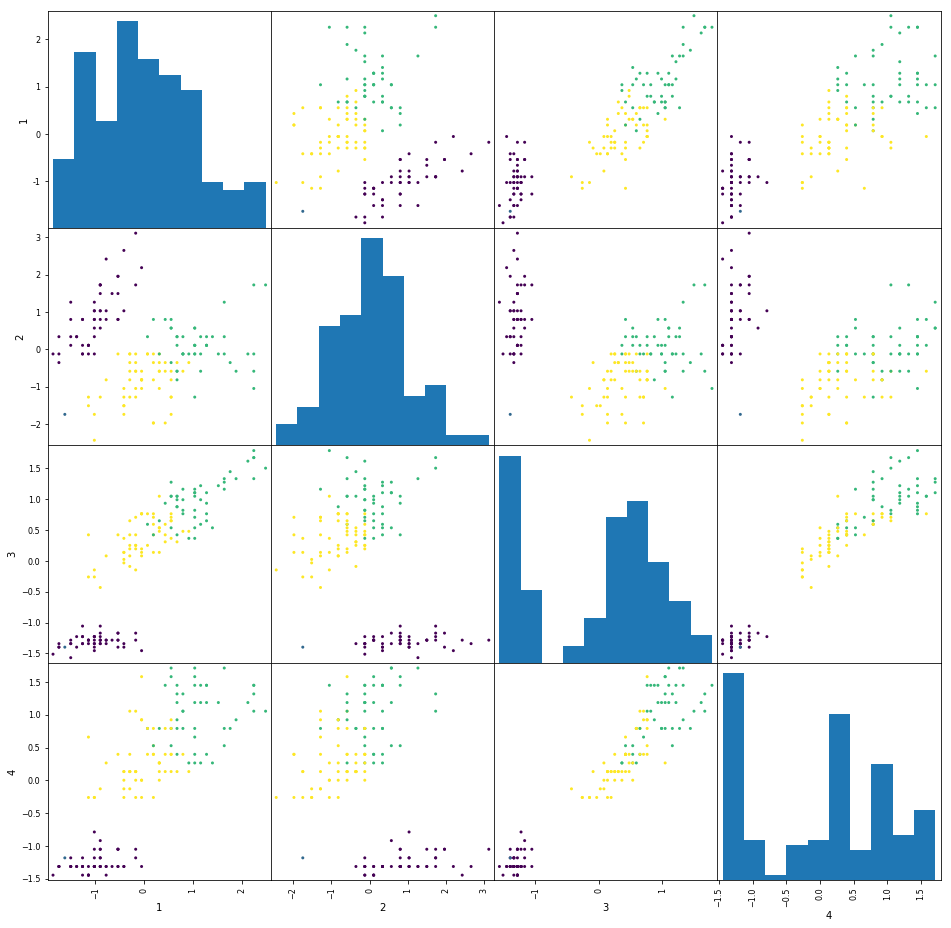

In [32]:
n = len(data)
clusterings = [spectral_obj, kmeans_obj, dbscan_obj, ms_obj]
recluster_what = 'points'
how = 'hierarchical'
k = 4

# Fit
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how)
consensus_obj.fit()
labels = consensus_obj.cluster_labels

# Plot
dataframecs=pd.DataFrame(data,columns=["1","2","3","4"])
dataframecs["labels"]=labels
s=scatter_matrix(dataframecs[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = labels)#, cmap='Set2')

check with "true" meaningful labels of the partition into three types of flowers

In [33]:
iris = sns.load_dataset("iris")
#iris_labels=load_iris_labeled() 

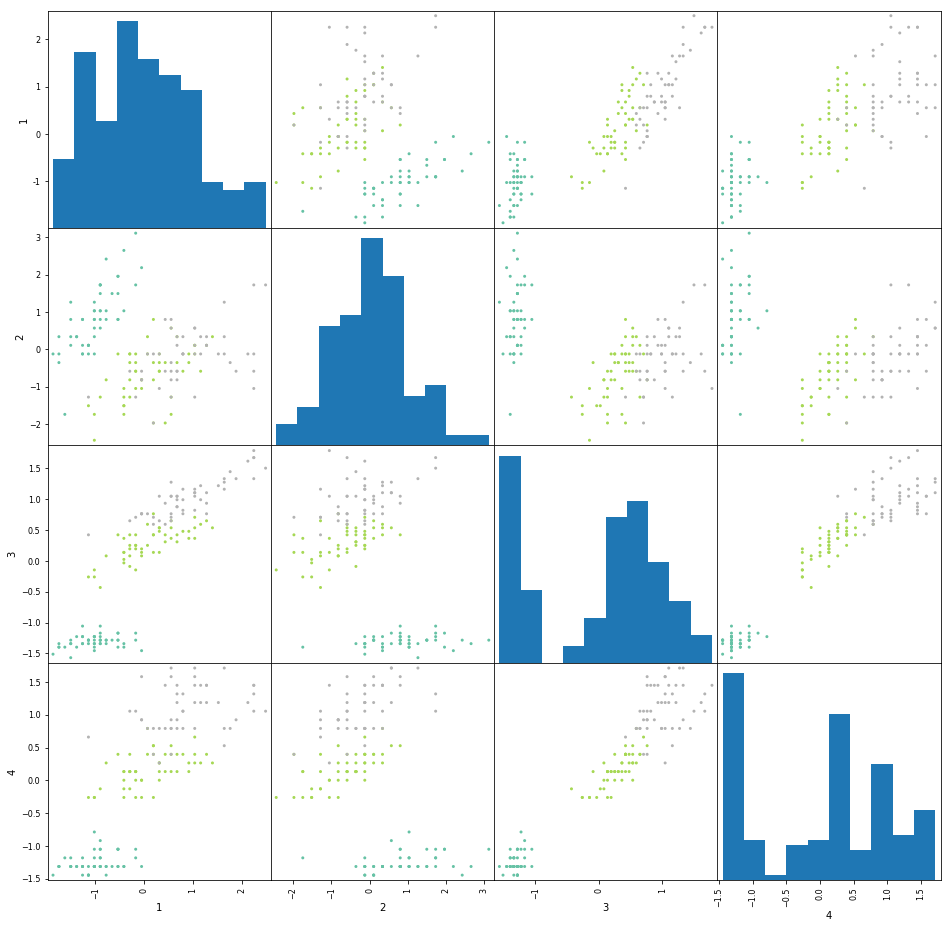

In [34]:
foundlabels=np.zeros((150,))
for j in range(150):
    if iris["species"][j]=='setosa':
        foundlabels[j]=0
    if iris["species"][j]=='versicolor':
        foundlabels[j]=1
    if iris["species"][j]=='virginica':
        foundlabels[j]=2
    
dataframelb=pd.DataFrame(data,columns=["1","2","3","4"])
dataframelb["labels"]=foundlabels
s=scatter_matrix(dataframelb[["1","2","3","4"]], alpha=1, figsize=(16, 16), c = dataframelb["labels"], cmap='Set2')


Calculating the Fowlkes-Mallows index to check how well the consensus clustering agrees with the expert/true cluster

In [35]:
# Calculating the Fowlkes-Mallows index which lies in [0 1], the closer to 1 the better
from sklearn import metrics
fm_index = metrics.fowlkes_mallows_score(foundlabels, labels) 
fm_index

0.73680993658522409

And the mutual information between the "true" clustering and the consensus clustering

In [36]:
mutinf = metrics.adjusted_mutual_info_score(foundlabels, labels)  
mutinf

0.6339808523515682